In [3]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline


import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])

from matplotlib import colors
from matplotlib import ticker

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/')
import functions_transport_W

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colour_list = [
"#96502e",
"#b25a30",
"#e96e33",
"#faf3dd",
"#69b0bc",
"#619ee4",
"#4b5bbb"]#[::-1]

cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [5]:
idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
ideal = idealf['Bathymetry'][:]
realf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_for_agrif.nc')
real = realf['Bathymetry'][:150, 55:]
xs = np.arange(real.shape[-1])# * 2 # index * 2.00 km
ys = np.arange(real.shape[-2])# * 2

In [6]:
real.shape

(150, 200)

In [10]:
def plot(fig, xs, ys, bathy, cmap, elev=60, azim=50, alpha=None):
    cmap, norm = cmap, MidpointNormalize(midpoint=30.0)#(midpoint=100.0)
    X, Y = np.meshgrid(xs, ys)
    
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    s = ax.plot_surface(X, Y, bathy, rstride=1, cstride=1, cmap=cmap, linewidth=0.2, antialiased=True, alpha=alpha, norm=norm)
    ax.view_init(elev=elev, azim=azim)
    ax.set_zlim(1300, 0)
    ax.set_xlim(0, xs[-1])
    ax.set_ylim(0, ys[-1])
    #rgba = (1.0, 1.0, 1.0, 1.0)
    #ax.w_xaxis.set_pane_color(rgba)
    #ax.w_yaxis.set_pane_color(rgba)
    #ax.w_zaxis.set_pane_color(rgba)
    #ax.zaxis._axinfo['grid']['color'] = 'w'
    #ax.yaxis._axinfo['grid']['color'] = 'w'
    #ax.xaxis._axinfo['grid']['color'] = 'w'
    c = ax.contour(X, Y, bathy, levels=[100, 200, 600], colors='k', linewidths=3)
    #ax.set_ylabel('Cross-Shore (Y) Distance [km]', fontsize=18, labelpad=30)
    #ax.set_xlabel('Along-Shore (X) Distance [km]', fontsize=18, labelpad=30)
    #ax.set_zlabel('Depth [m]', fontsize=18, labelpad=10)
    fig.colorbar(s)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    return fig

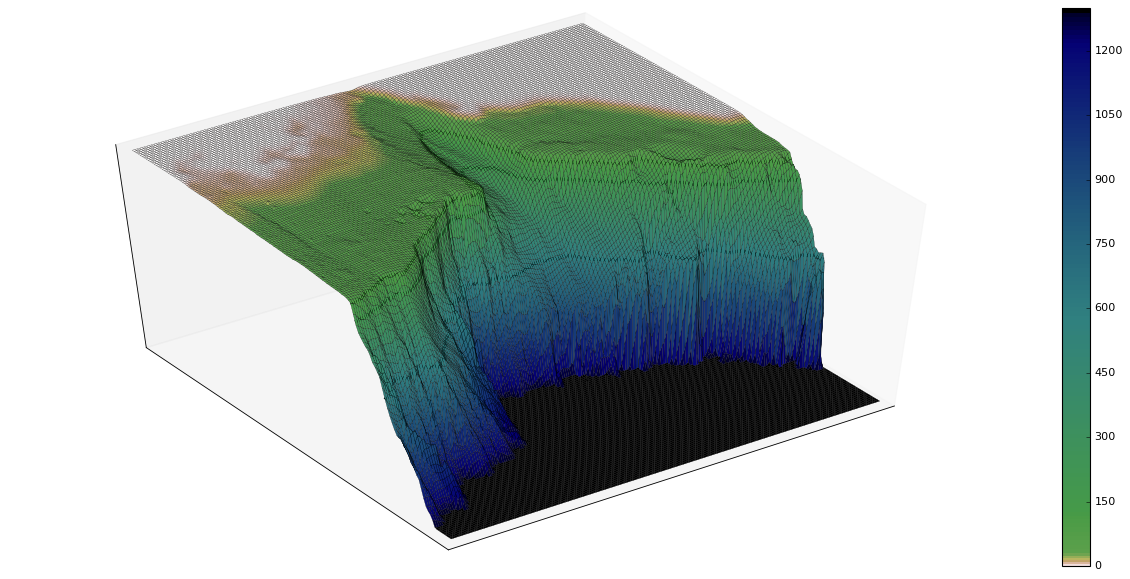

In [11]:
fig = plt.figure(figsize=(20, 9))
fig = plot(fig, xs, ys, real, cm.gist_earth_r, elev=50, azim=55)
fig.savefig('real_3MT.png', dpi=800)

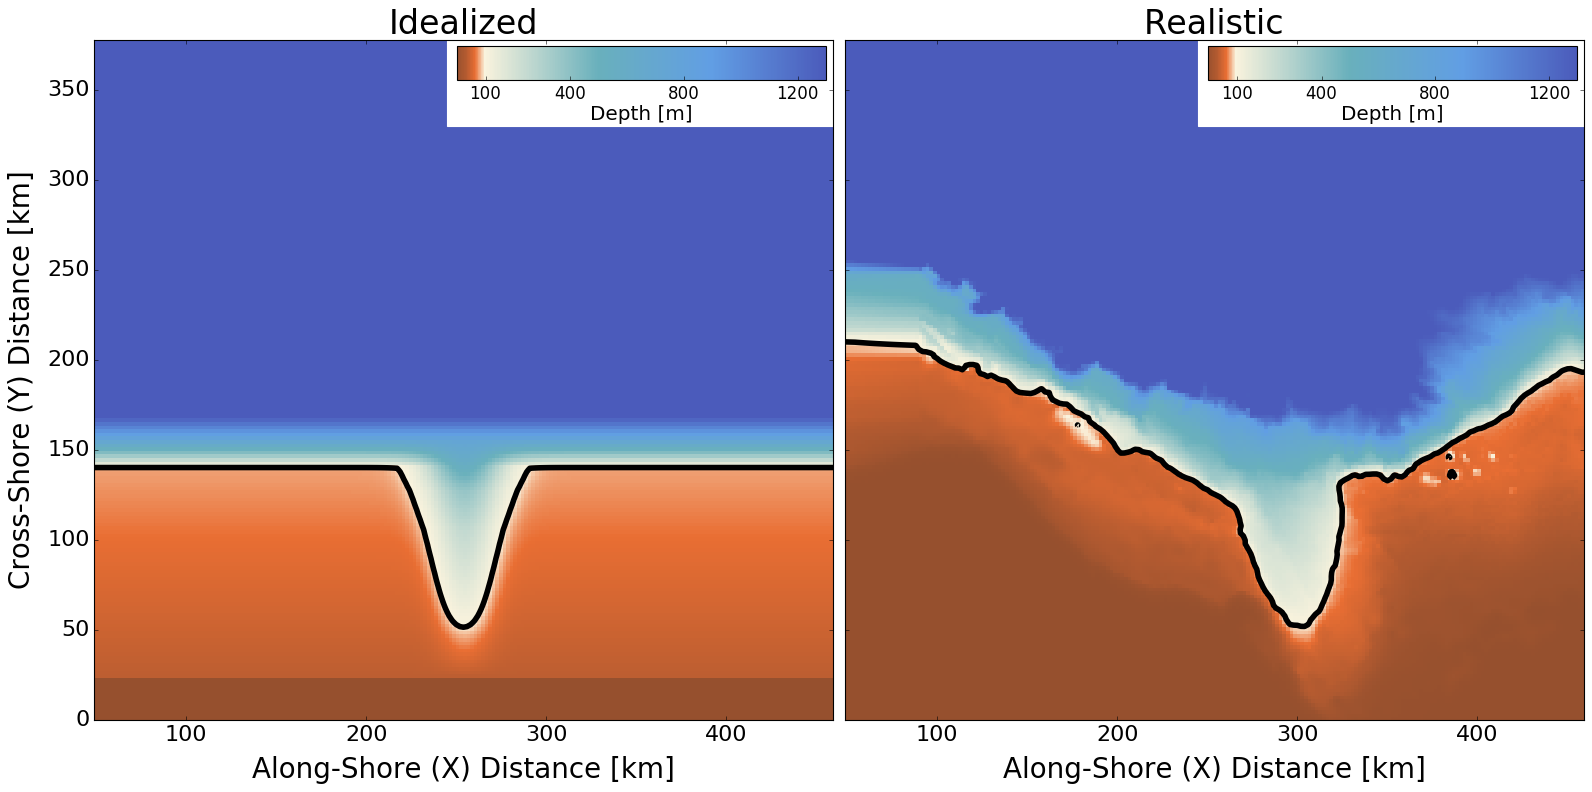

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
norm = MidpointNormalize(midpoint=100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10),sharey=True)
for ax, plot, n, ttl in zip([ax1, ax2], [ideal, real], np.arange(2), ['Idealized', 'Realistic']):
    p = ax.pcolormesh(xs, ys, plot, cmap=cmap, norm=norm, vmin=0, vmax=1300)
    ax.set_xlim([0, xs[-1]])
    ax.set_ylim([0, ys[-1]])
    ax.set_aspect(aspect='equal')
    ax.add_patch(patches.Rectangle((245, 330),250,50, color='white'))
    ax.contour(xs, ys, plot, levels=[100], colors='k', linewidths=5)
    axins = inset_axes(ax,
                    width="50%",  # width = 10% of parent_bbox width
                    height="5%",  # height : 50%
                    loc=1)
    axins.xaxis.set_ticks_position("bottom")
    cbar = fig.colorbar(p, cax=axins, orientation="horizontal", ticks=[100, 400, 800, 1200])
    ax.set_title(ttl, fontsize=30)
    cbar.set_label('Depth [m]', fontsize=18, labelpad=2.5)
    if ax == ax1:
        ax.set_ylabel('Cross-Shore (Y) Distance [km]', fontsize=25, labelpad=10)
    ax.set_xlabel('Along-Shore (X) Distance [km]', fontsize=25, labelpad=10)
    cbar.ax.tick_params(labelsize=15)
    ax.tick_params(axis='both', which='both', labelsize=20)

fig.tight_layout()
fig.savefig('bathy_topdown.png')

In [75]:
fig = plt.figure(figsize=(20, 9))
fig = plot(fig, xs, ys, real, cmap, elev=50, azim=130)
plt.savefig('../../OSM_images/bathy_real.png')

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
fig = plt.figure(figsize=(20, 9))
fig = plot(fig, xs, ys, ideal, cmap, elev=50, azim=130)
plt.savefig('../../OSM_images/bathy_ideal.png')

# Other

In [6]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'
gdepw, tmask, mbathy, e1t, e2t = functions_transport_W.get_variables_planes(dirname, filename)
filename = '1_mesh_mask_nocanyon.nc'
gdepwn, tmaskn, mbathyn, e1tn, e2tn = functions_transport_W.get_variables_planes(dirname, filename)

In [7]:
surface_mask = functions_transport_W.get_surface_mask(tmaskn, mbathyn)

In [8]:
surface_mask.shape

(80, 272, 242)

In [9]:
real.shape

(190, 255)

In [11]:
idealnf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif_nocanyon.nc')
idealn = idealnf['Bathymetry'][:]

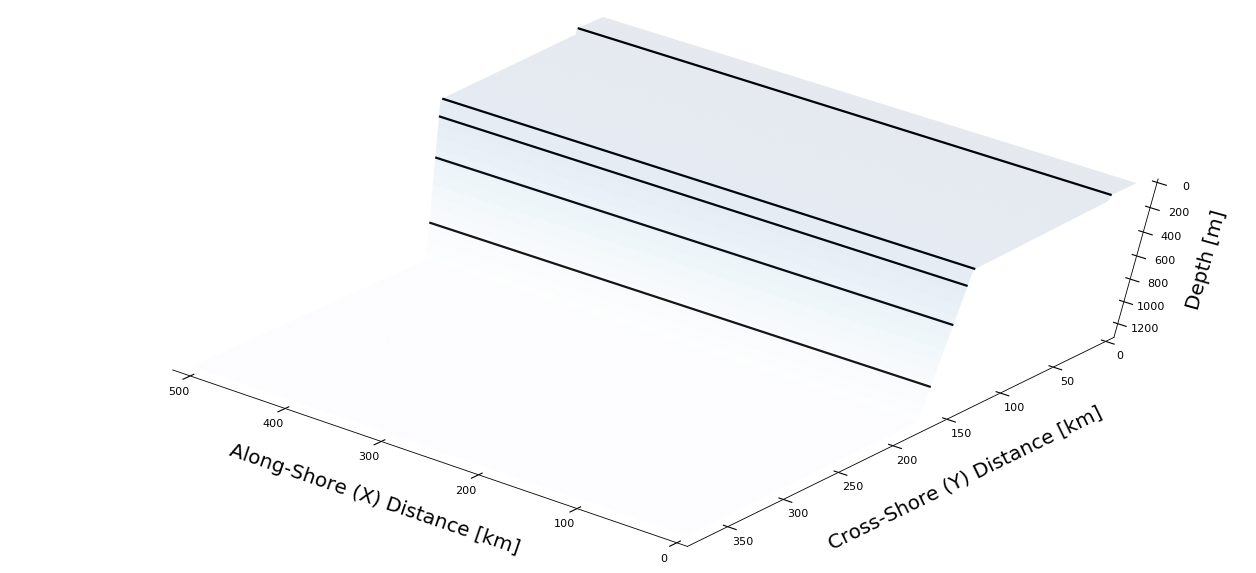

In [26]:
fig = plt.figure(figsize=(20, 9))
fig = plot(fig, xs, ys, ideal, cm.Spectral, elev=60, azim=130)
fig = plot(fig, xs, ys, idealn, cm.Blues_r, elev=60, azim=130, alpha=0.1)

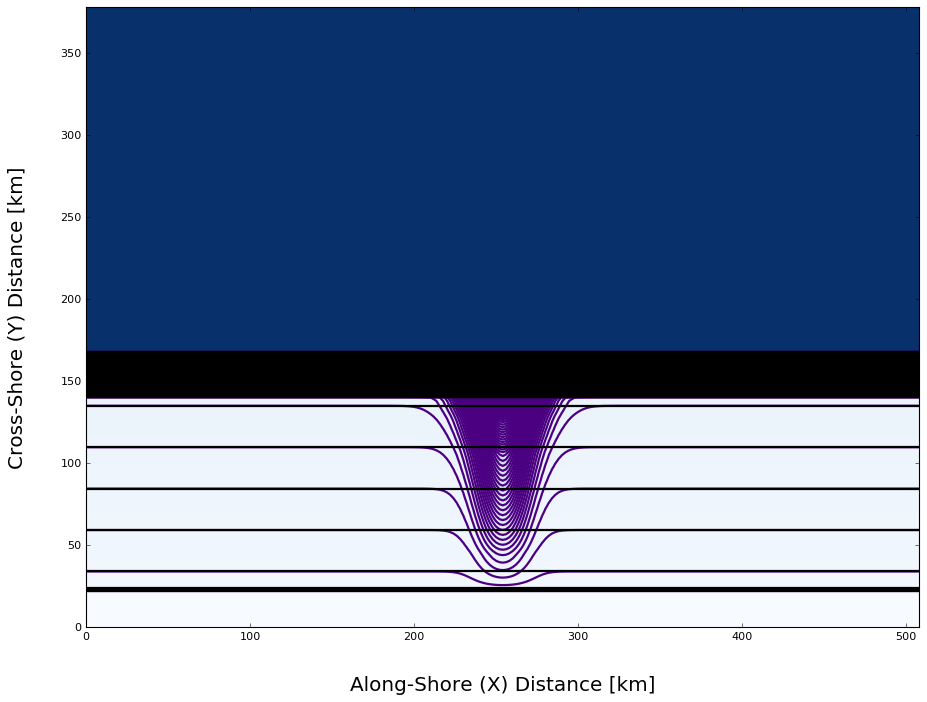

In [70]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))
p = ax.pcolormesh(xs, ys, ideal[:], cmap=cm.Blues)
levels = np.arange(0, 1300, 8.7)
c = ax.contour(xs, ys, ideal[:], levels = levels, colors='indigo', linewidths=2)
cn = ax.contour(xs, ys, idealn[:], levels = levels, colors='k', linewidths=2)
ax.set_ylabel('Cross-Shore (Y) Distance [km]', fontsize=18, labelpad=30)
ax.set_xlabel('Along-Shore (X) Distance [km]', fontsize=18, labelpad=30)
ax.set_aspect(aspect='equal')
plt.savefig('rim_lid.png')

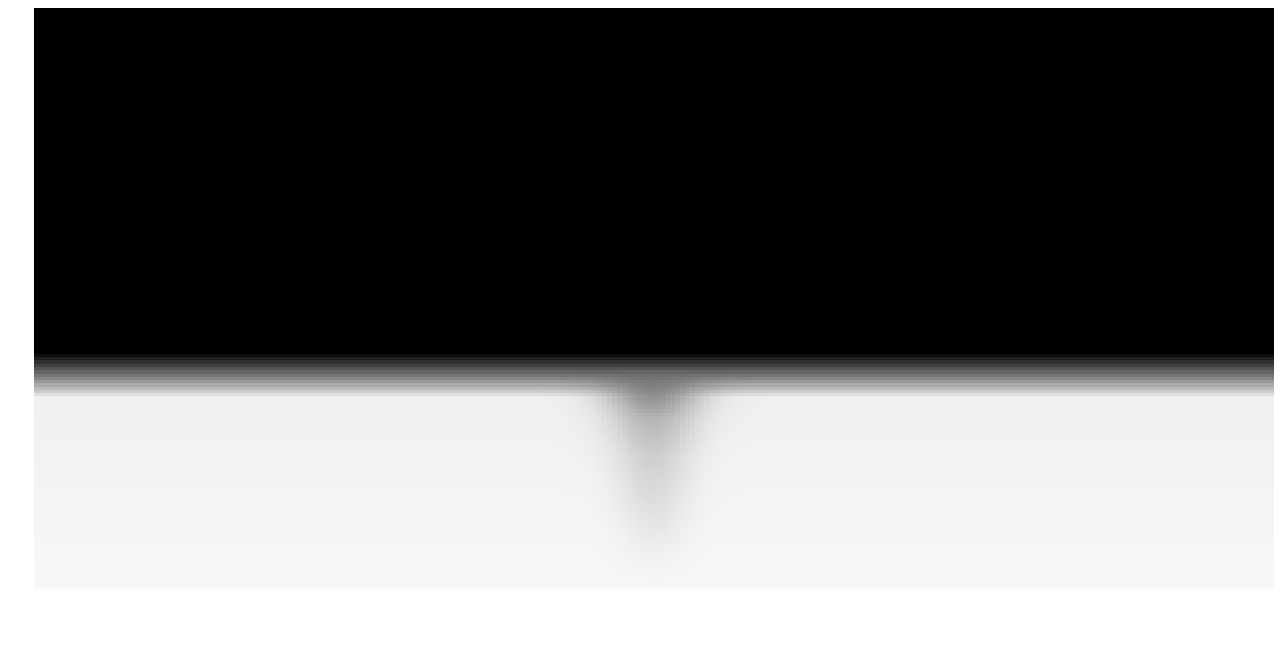

In [8]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))
ax.pcolormesh(ideal, cmap = cm.gray_r)
ax.set_xlim([0, ideal.shape[-1]])
ax.set_ylim([0, ideal.shape[-2]])
plt.axis('off')
plt.savefig('gray_bathy.png')